# Exploring `build_renewable_profiles.py` outputs

This notebook explains how renewable potential is assessed by the model. To understand it we have to focus on the `build_renewable_profiles.py` **outputs**. The outputs are timeseries of wind or solar power plants as well as the resource potential. There are two types of **potentials**, 
- technical installable power potential [MW] which does not need profiles (area demand per tech. MW/km^2 * general available area m^2 * availability factor) 
- technical 'resource' energy potential [MWh] which needs hourly per unit profiles & the above power potential

In this notebook we consider both.

## Data needed

The `pypsa-earth/Snakefile` explicitly list in the **rule** what goes into the function `build_renewable_profiles.py` and what goes out (`build_renewable_profiles_{technology}.nc`). So to create the renewable timeseries, we need to provide:
- the base_network
- natura raster, areas where renewables are excluded i.e. areas under protection (generated in `build_natura_raster`)
- copernicus, global land cover data (classifies land data)
- gebco, bathemetry data (deepness of sea)
- cutout, environmental data timeseries such as wind speed and irradiation

All the data needed for Africa are currently supplied with the model. The plan for the future is to provide global data. The base network may be generated with `base_network` rule and may be obtained by running this single rule `snakemake -j 1 base_network` or the whole workflow `snakemake -j 1 solve_all_networks`.

## Structure of the `build_renewable_profiles` rule

The rule inputs and outputs looks like that (you can find this fragment in the Snakemake file):

```
rule build_renewable_profiles:
    input:
        base_network="networks/base.nc",
        natura="resources/natura.tiff",
        copernicus="data/raw/copernicus/PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif",
        gebco="data/raw/gebco/GEBCO_2021_TID.nc",
        country_shapes='resources/country_shapes.geojson',
        offshore_shapes='resources/offshore_shapes.geojson',
        regions=lambda w: ("resources/regions_onshore.geojson"
                                   if w.technology in ('onwind', 'solar', "hydro")
                                   else "resources/regions_offshore.geojson"),
        cutout=lambda w: "cutouts/" + config["renewable"][w.technology]['cutout'] + ".nc",
    output: profile="resources/profile_{technology}.nc",
    log: "logs/build_renewable_profile_{technology}.log"
    benchmark: "benchmarks/build_renewable_profiles_{technology}"
    threads: ATLITE_NPROCESSES
    resources: mem=ATLITE_NPROCESSES * 5000
    script: "scripts/build_renewable_profiles.py"
```

In [1]:
# set current folders
import sys
import os

# change current directory to pypsa-earth folder
os.chdir("../../../pypsa-earth")

A jupyter notebook requires the user to import all they need. So we need to import all the required dependencies from the `pypsa-earth` environment:

In [2]:
import atlite
import cartopy.crs as ccrs
import cartopy
import xarray as xr
import geopandas as gpd

# import holoviews as hv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer


plt.rcParams["figure.figsize"] = [7, 7]
%matplotlib inline

## Generate profiles separately

If you don't have the renewable profiles such as:
- `resources/profile_solar.nc`
- `resources/profile_onwind.nc`
- `resources/profile_offwind-ac.nc`

you could try to generate them from the terminal. For that purpose please use the command:

```
snakemake -j 1 resources/renewable_profiles/profile_{technology}.nc
```

replacing {technology} for the timeseries of interest (hydro, offwind-dc, solar, offwind-ac, onwind).

## Let's open the profiles
The `build_renewable_profiles` for each technology are stored in the `resources` folder. We read first the path and open then with xarray the .nc file. As you can see there is quite a lot data available.  What you should note is that only the `potential` is gridded (can be shown in a nice raster on a map). From the `profiles` we can only retrieve timeseries data without mapping it.

In [3]:
solar_path = os.path.realpath("resources/renewable_profiles") + "/profile_solar.nc"
solar = xr.open_dataset(solar_path)

wind_path = os.path.realpath("resources/renewable_profiles") + "/profile_onwind.nc"
wind = xr.open_dataset(wind_path)
wind

<xarray.Dataset>
Dimensions:           (time: 8760, bus: 156, y: 257, x: 291)
Coordinates:
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
  * bus               (bus) object '0' '1' '3' '5' ... '189' '190' '191' '192'
  * y                 (y) float64 -37.5 -37.2 -36.9 -36.6 ... 38.7 39.0 39.3
  * x                 (x) float64 -19.5 -19.2 -18.9 -18.6 ... 66.9 67.2 67.5
Data variables:
    profile           (time, bus) float64 ...
    weight            (bus) float64 ...
    p_nom_max         (bus) float64 ...
    potential         (y, x) float64 ...
    average_distance  (bus) float64 ...

### Technical installable power potential [GW]

In [4]:
def plot_raster(
    data,
    region,
    cmap="Blues",
    figsize=(10, 10),
    projection=ccrs.PlateCarree(),
    cb_label="potential",
    gridlabels=False,
    title="title",
    filename=None,
    format="pdf",
):
    # beauty therapy for plots
    font_scale = figsize[0] / 10  # according to width
    plt.rcParams.update({"font.size": 17 * font_scale})
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": projection})

    # onshore potential raster
    (data / 1000).plot(
        ax=ax,
        cmap=cmap,
        edgecolor="grey",
        linestyle=":",
        add_colorbar=True,
        cbar_kwargs={"shrink": 1, "label": cb_label},
    )

    # black edge around country or continent shape
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    shapes_country = world[world.name.isin(region)]
    shapes_continent = world[world.continent.isin(region)]
    shapes = pd.concat([shapes_country, shapes_continent])
    shapes.plot(ax=ax, edgecolor="k", color="None")

    # set extent
    buffer = 0.5
    minx, miny, maxx, maxy = (shapes.to_crs(ccrs.PlateCarree()).bounds).values.flatten()
    minx, miny = [minx - buffer, miny - buffer]
    maxx, maxy = [maxx + buffer, maxy + buffer]
    ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())  # Nigeria

    if gridlabels == True:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = False
        gl.ylines = False
        gl.xlabel_style = {"size": 12 * font_scale}
        gl.ylabel_style = {"size": 12 * font_scale}

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

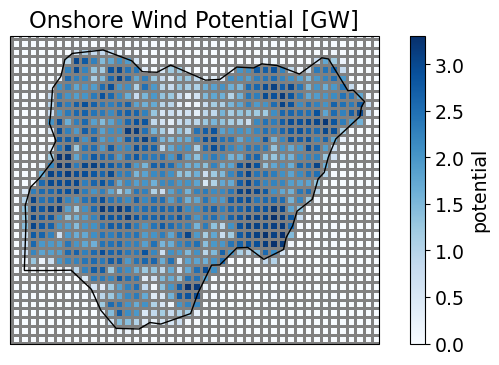

In [5]:
plot_raster(
    wind.potential,
    ["Nigeria"],
    cmap="Blues",
    figsize=(8, 4),
    projection=ccrs.PlateCarree(),
    cb_label="potential",
    gridlabels=False,
    title="Onshore Wind Potential [GW]",
    # filename="rasterized-onshore-wind-potential.pdf"
)

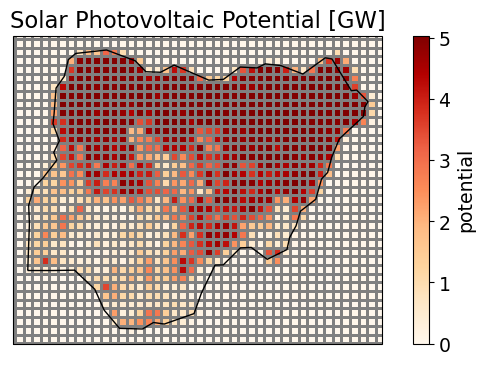

In [6]:
plot_raster(
    solar.potential,
    ["Nigeria"],
    cmap="OrRd",
    figsize=(8, 4),
    projection=ccrs.PlateCarree(),
    cb_label="potential",
    gridlabels=False,
    title="Solar Photovoltaic Potential [GW]",
    # filename="rasterized-solvar-pv-potential.pdf"
)

### Technical installable potential in bus regions. Provided by Fabian Neumann.

In [7]:
def plot_map(data, cmap, projection, voronoi=None, title=None, filename=None):
    plt.rcParams.update({"font.size": 12})
    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    data.plot.imshow(
        ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, label="potential [MW]"
    )
    # contourf
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent([2, 14.5, 3, 14], crs=ccrs.PlateCarree())  # Nigeria
    resource_path = os.path.realpath("resources")
    if voronoi == "onshore":
        br = gpd.read_file(f"{resource_path}/bus_regions/regions_{voronoi}.geojson")
        br.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            facecolor="none",
            linewidth=0.25,
            edgecolor="k",
        )
    elif voronoi == "offshore":
        br = gpd.read_file(f"{resource_path}/bus_regions/regions_{voronoi}.geojson")
        br.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            facecolor="none",
            linewidth=0.25,
            edgecolor="k",
        )

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

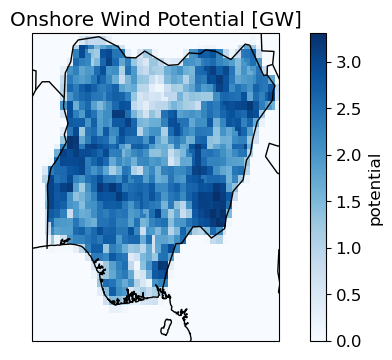

In [8]:
plot_map(
    wind.potential / 1000,
    "Blues",
    ccrs.Orthographic(),
    voronoi="onshore",
    title="Onshore Wind Potential [GW]",
    # filename="onwind-gridcell.pdf",
)

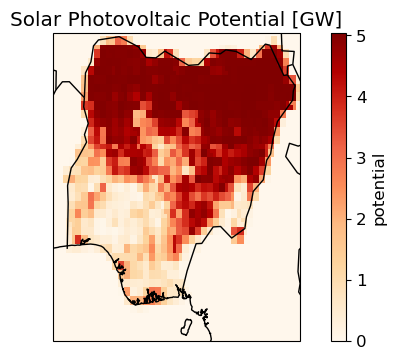

In [9]:
plot_map(
    solar.potential / 1000,
    "OrRd",
    ccrs.Orthographic(),
    voronoi="onshore",
    title="Solar Photovoltaic Potential [GW]",
    # filename="solar-gridcell.pdf",
)

In [10]:
resource_path = os.path.realpath("resources")
network_path = os.path.realpath("networks")
br = gpd.read_file(f"{resource_path}/bus_regions/regions_onshore.geojson")
elec = pypsa.Network(f"{network_path}/elec.nc")

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


In [11]:
def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):

    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(f"resources/bus_regions/regions_{voronoi}.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_nom_max"].max(),
        legend=True,
        legend_kwds={"label": r"potential density"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent([2, 14.5, 3, 14], crs=ccrs.PlateCarree())  # Nigeria

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

/var/folders/qn/vpndfm21795ckkq89np1ckp40000gn/T/ipykernel_33504/2468176908.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area


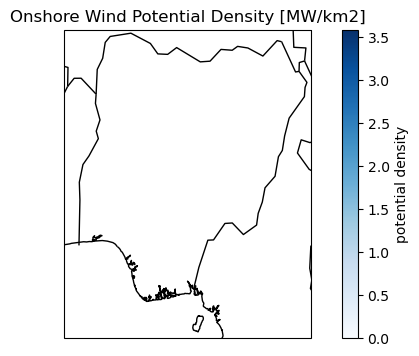

In [12]:
plot_voronoi(
    elec,
    "onwind",
    "onshore",
    "Blues",
    ccrs.Orthographic(),
    title="Onshore Wind Potential Density [MW/km2]",
    # filename="onwind-cell.pdf",
)

/var/folders/qn/vpndfm21795ckkq89np1ckp40000gn/T/ipykernel_33504/2468176908.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area


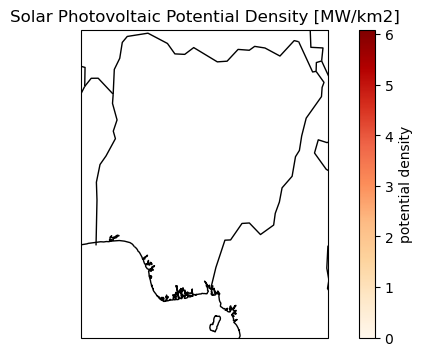

In [13]:
plot_voronoi(
    elec,
    "solar",
    "onshore",
    "OrRd",
    ccrs.Orthographic(),
    title="Solar Photovoltaic Potential Density [MW/km2]",
    # filename="solar-cell.pdf",
)

### Technical 'resource' energy potential [TWh]

In [14]:
technical_solar_potential_twh = (
    sum(solar["p_nom_max"] * solar["profile"]).sum() / 10**6
)  # MWh to TWH conversion
technical_wind_potential_twh = (
    sum(wind["p_nom_max"] * wind["profile"]).sum() / 10**6
)  # MWh to TWH conversion

print(
    f"Technical solar potential: {technical_solar_potential_twh.values} \n",
    f"Technical wind potential: {technical_wind_potential_twh.values}",
)

Technical solar potential: 3936.9278877614215 
 Technical wind potential: 1201.0062011179239


## Timeseries
Timeseris plots are helpful to analyse the seasonality and general variability. Below we show how you could plot some of these.

Text(0.5, 1.0, '')

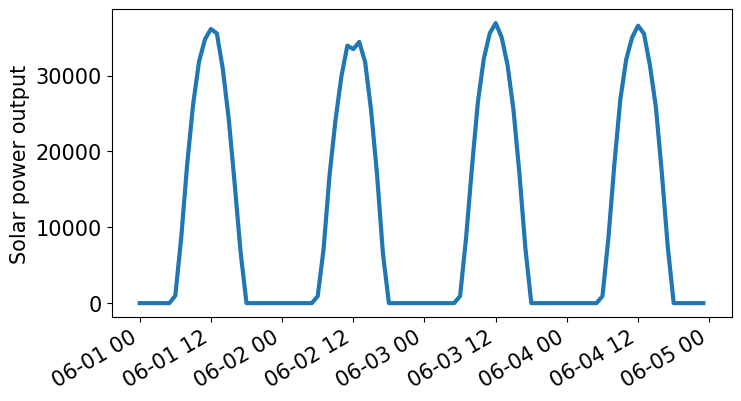

In [15]:
plt.rcParams.update({"font.size": 15})
fig, ax = plt.subplots(figsize=(8, 4))

# max_installable_capacity [MX] * profiles [p.u.]
solar_profile_mw = solar["p_nom_max"] * solar["profile"]

solar_profile_mw.sel(bus="0", time=slice("2013-06-01", "2013-06-04")).plot(
    ax=ax, linewidth=3
)
ax.set_xlabel(None)
ax.set_ylabel("Solar power output")
ax.set_title(None)

# plt.savefig("solar-power-profile.pdf", bbox_inches="tight")

Text(0.5, 1.0, '')

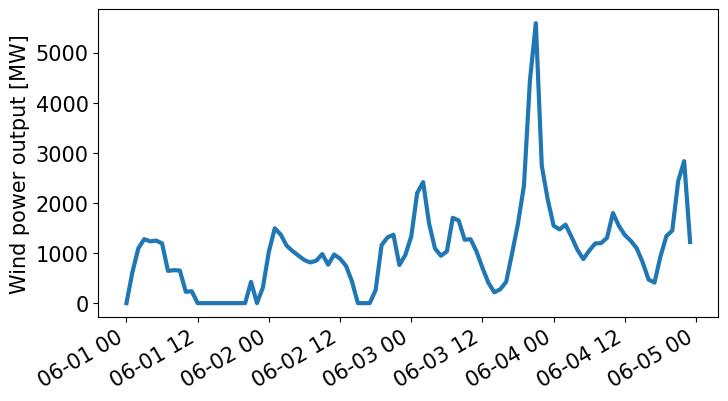

In [16]:
plt.rcParams.update({"font.size": 15})
fig, ax = plt.subplots(figsize=(8, 4))

# max_installable_capacity [MX] * profiles [p.u.]
wind_profile_mw = wind["p_nom_max"] * wind["profile"]

wind_profile_mw.sel(bus="5", time=slice("2013-06-01", "2013-06-04")).plot(
    ax=ax, linewidth=3
)
ax.set_xlabel(None)
ax.set_ylabel("Wind power output [MW]")
ax.set_title(None)

# plt.savefig("onshore-wind-power-profile.pdf", bbox_inches="tight")

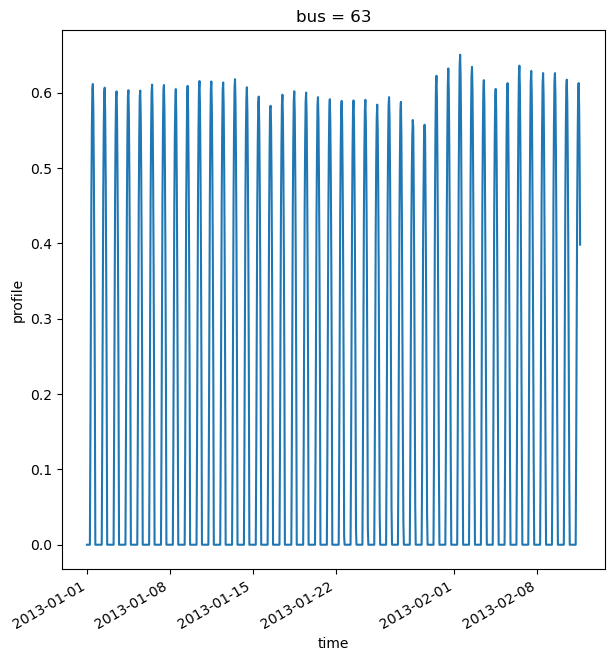

In [17]:
plt.rcParams.update({"font.size": 10})
solar["profile"].isel(bus=sum(range(10)), time=range(0, 1000)).plot()